In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 原始数据转序列

In [2]:
#读取数据
filename = 'data/stay_one_community_with_7ptype_week.csv'
act_points = pd.read_csv(filename,parse_dates=['t_start', 't_end'])
act_points['date'] = pd.to_datetime(act_points['date'],format='%Y-%m-%d')
act_points.head()

,pid,date,t_start,t_end,poi_id,longitude,latitude,community_id,ptype,week,weekday,month,happen_time,duration_time,home_distance,work_distance
0,117999,2020-01-01,2020-01-01 00:12:42,2020-01-01 23:07:21,0,114.173201,22.640610,2291,0,1,2,1,12,1375,5.853701e-12,1.176146e+01
1,117999,2020-01-02,2020-01-02 00:04:02,2020-01-02 07:01:15,0,114.173201,22.640610,2291,0,1,3,1,4,417,5.853701e-12,1.176146e+01
2,117999,2020-01-02,2020-01-02 07:55:20,2020-01-02 21:26:58,1,114.059819,22.654923,2291,2,1,3,1,475,812,1.176146e+01,1.023036e-11
3,117999,2020-01-02,2020-01-02 22:00:40,2020-01-02 23:16:47,0,114.173201,22.640610,2291,0,1,3,1,1320,76,5.853701e-12,1.176146e+01
4,117999,2020-01-03,2020-01-03 00:47:55,2020-01-03 07:01:43,0,114.173201,22.640610,2291,0,1,4,1,47,374,5.853701e-12,1.176146e+01


In [8]:
# 生成月份标签
act_points['month'] = [data.month for data in act_points['date']]

In [9]:
#删除不满7天的周数据，即（2020-01-01到2020-01-05）
from datetime import datetime
dt1 = datetime(2020,1,1)
dt2 = datetime(2020,1,5)
act_points1 = act_points.drop(act_points[(act_points.date >= dt1) & (act_points.date <= dt2)].index).reset_index(drop=True)

In [ ]:
#原始ptype：0-到访，1-居住，2-工作，3-出行，
#为了wft，令0-居住（基点），1-出行，2-工作，3-其他
dict_ = {0:3, 1:0, 2:2}
act_points1['ptype'] = act_points1['ptype'].map(dict_)

In [5]:
act_points1.head()

,pid,date,t_start,t_end,poi_id,longitude,latitude,community_id,ptype,week,weekday,month
0,117999,2020-01-06,2020-01-06 00:12:16,2020-01-06 07:33:01,0,114.173201,22.640610,2291,0,2,0,1
1,117999,2020-01-06,2020-01-06 08:03:35,2020-01-06 14:41:18,1,114.059819,22.654923,2291,2,2,0,1
2,117999,2020-01-06,2020-01-06 14:42:33,2020-01-06 18:02:33,1,114.059819,22.654923,2291,2,2,0,1
3,117999,2020-01-06,2020-01-06 18:20:11,2020-01-06 22:37:40,0,114.173201,22.640610,2291,0,2,0,1
4,117999,2020-01-07,2020-01-07 00:22:34,2020-01-07 07:36:28,0,114.173201,22.640610,2291,0,2,1,1


In [4]:
#一天为单位构建序列。0-居住（基点），1-出行，2-工作，3~7-其他
#序列长度24*60=1440
def act_2_sequence_in_day(act):
    from datetime import datetime
    sequence = np.zeros(1440)
#     if (len(act)==1) & (act['ptype'][0]==1):
#         return sequence;
#     else:
    for index in range(len(act)):
    #for data in act:
        data = act.iloc[index,:]
        
        #一个问题：要考虑隔日的活动，如从23:00到次日1:00
        #解决方法：将t_start，t_end与date比较，并进行截断，t_start->0:00，t_end->23:59
        if data['t_start'].day != data['date'].day:
            data['t_start'] = datetime(data['date'].year,data['date'].month,data['date'].day,0,0,0)
        elif data['t_end'].day != data['date'].day:
            data['t_end'] = datetime(data['date'].year,data['date'].month,data['date'].day,23,59,59)

        #根据时间段修改初始活动类型
        act_begin = data['t_start'].hour*60+data['t_start'].minute
        act_end = data['t_end'].hour*60+data['t_end'].minute
        sequence[act_begin:act_end] = [data['ptype'] for i in range(act_end - act_begin)]

        #根据相邻活动的时间段加入出行，对出行时长小于15min且出行连接的活动类型一样的要去掉
        if index < len(act)-1:
            #下一个活动的数据
            data1 = act.iloc[index+1,:]
            #定义出行时间
            trip_begin = data['t_end'].hour*60+data['t_end'].minute
            trip_end = data1['t_start'].hour*60+data1['t_start'].minute
            if (trip_end - trip_begin < 15) & (data['ptype'] == data1['ptype']):
                sequence[trip_begin:trip_end] = [data['ptype'] for i in range(trip_end - trip_begin)]
            else:
                sequence[trip_begin:trip_end] = [1 for i in range(trip_end - trip_begin)]
    return sequence

In [5]:
#以周为单位构建长时间序列（周一到周日为一周）,采取将天序列拼接后再reshape的方法
#序列长度24*60*7=10080
def act_2_sequence_in_week(act):
    from datetime import datetime
    Sequence_in_week = []
    
    for weekday in range(7):
        
        act_day = act.query(f'weekday=={weekday}')
        sequence = np.zeros(1440)
        for index in range(len(act_day)):
            
            data = act_day.iloc[index,:]

            #考虑隔日的活动，如从23:00到次日1:00 → t_start，t_end与date比较，并进行截断，t_start->0:00，t_end->23:59
            if data['t_start'].day != data['date'].day:
                data['t_start'] = datetime(data['date'].year,data['date'].month,data['date'].day,0,0,0)
            elif data['t_end'].day != data['date'].day:
                data['t_end'] = datetime(data['date'].year,data['date'].month,data['date'].day,23,59,59)

            #根据时间段修改初始活动类型
            act_begin = data['t_start'].hour*60 + data['t_start'].minute
            act_end = data['t_end'].hour*60 + data['t_end'].minute
            sequence[act_begin:act_end] = [data['ptype'] for i in range(act_end - act_begin)]

            #根据相邻活动的时间段加入出行，对出行时长小于15min且出行连接的活动类型一样的要去掉
            if index < len(act_day)-1:
                #下一个活动的数据
                data1 = act_day.iloc[index+1,:]
                #定义出行时间
                trip_begin = data['t_end'].hour*60 + data['t_end'].minute
                trip_end = data1['t_start'].hour*60+data1['t_start'].minute

                if (trip_end - trip_begin < 15) & (data['ptype'] == data1['ptype']):
                    sequence[trip_begin:trip_end] = [data['ptype'] for i in range(trip_end - trip_begin)]
                else:
                    sequence[trip_begin:trip_end] = [1 for i in range(trip_end - trip_begin)]
        
        Sequence_in_week.append(sequence)
    
    Sequence_in_week = np.array(Sequence_in_week).reshape(10080)
    
    return Sequence_in_week

In [4]:
#对个体和日期分组求序列
trajectory_groups_in_day = act_points.groupby(['pid','date'],group_keys=False)
trajectory_in_day = trajectory_groups_in_day.apply(act_2_sequence_in_day).reset_index(drop=True)
trajectory_in_day.head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [16]:
# 对个体和周序号分组求序列
trajectory_groups_in_week = act_points1.groupby(['pid','week'],group_keys=False)
trajectory_in_week = trajectory_groups_in_week.apply(act_2_sequence_in_week).reset_index(drop=True)
trajectory_in_week.head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [5]:
len(trajectory_in_day)

6891

Text(0.5, 1.0, 'categorial time series')

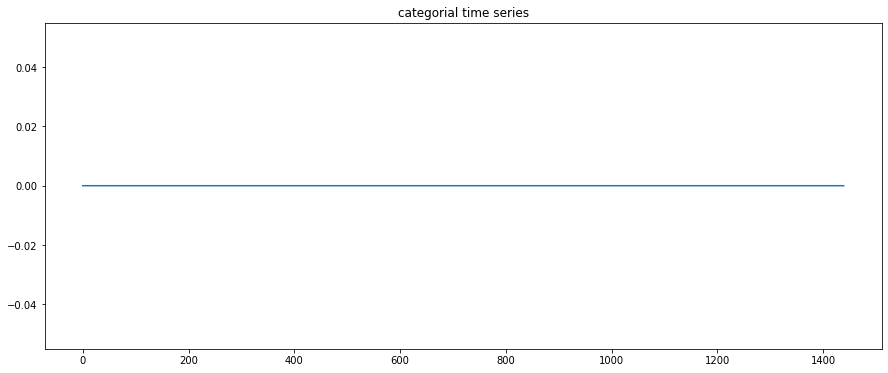

In [6]:
# 画个图看看
plt.figure(figsize=(15,6))
plt.plot(trajectory_in_day[0])
plt.title('categorial time series')

In [7]:
# 删除整天在家的轨迹（自成一类，不需分析）
trajectory_out = trajectory_in_day
for index,data in enumerate(trajectory_out):
    #print(data)
    if (~data.any()):
        trajectory_out = trajectory_out.drop(index = index)

trajectory = trajectory_out.reset_index(drop = True)

In [70]:
# 删除整周在家的轨迹（自成一类，不需分析）
trajectory_out = trajectory_in_week
for index,data in enumerate(trajectory_out):
    #print(data)
    if (~data.any()):
        trajectory_out = trajectory_out.drop(index = index)

trajectory = trajectory_out.reset_index(drop = True)

In [8]:
len(trajectory)

5102

In [15]:
# #转化为ndarry方便保存
# Trajectory = []
# for i in range(len(trajectory)):
#     Trajectory.append(trajectory[i])

In [9]:
trajectory = trajectory_in_day
len(trajectory)

6891

In [72]:
#转化为ndarry方便保存
Trajectory_in_week = []
for i in range(len(trajectory)):
    Trajectory_in_week.append(trajectory[i])

In [10]:
#转化为ndarry方便保存
Trajectory_in_day = []
for i in range(len(trajectory)):
    Trajectory_in_day.append(trajectory[i])

In [11]:
#保存一下
np.savetxt("data/trajectory_day_7ptype_2020.txt", Trajectory_in_day)

In [73]:
#保存一下
np.savetxt("data/trajectory_in_week.txt", Trajectory_in_week)

## walsh-flourier transform

From Wikipedia: The Hadamard transform (also known as the Walsh–Hadamard transform, Hadamard–Rademacher–Walsh transform, Walsh transform, or Walsh–Fourier transform) is an example of a generalized class of Fourier transforms. It performs an orthogonal, symmetric, involutive, linear operation on 2^m real numbers (or complex numbers, although the Hadamard matrices themselves are purely real).

In [14]:
# wft, copy from chen et.al.
def wft(x,num):
    Ipower = np.zeros(15) #时间序列长度不大于2^15
    y = np.zeros(num)
    
    
    for i in range(num):
        IB = i
        IL=0
        
        while True:
            IBD = int(IB/2)
            Ipower[IL] = 0 if IB == (IBD * 2) else 1
                
            if IB == 0 or IBD == 0:
                break
            IB = IBD
            IL = IL + 1
        
        IP = 0
        IFAC = num
        for t1 in range(IL+1):
            IFAC = int (IFAC / 2)
            IP = int (IP + IFAC * Ipower[t1])
        
        y[IP] = x[i]
        
    
    x = y.copy()
    Iter = int(np.log2(num))
    for M in range(Iter):
        nump = 1 if M==0 else int(nump*2)
        Mnum = int (num / nump)
        Mnum2 = int(Mnum / 2)
        alph = 1
        for MP in range(nump):
            IB = int(MP * Mnum)
            
            for MP2 in range(Mnum2):
                mnum21 = int(Mnum2 + MP2 + IB) 
                IBA = int(IB + MP2)
                y[IBA] = x[IBA] + alph * x[mnum21]
                y[mnum21] = x[IBA] - alph * x[mnum21]

            alph = -alph
        
        r = np.power(num,-0.5)
        for i in range(num):
            x[i] = y[i] * r
        
    return y

In [119]:
# WFT测试
# test = np.array([1,2,3,4,5,6,7])
# #test = np.ones(1440)
# dim = len(test)
# next2 = np.power(2,int(np.log2(dim)+1))
# WFTs = []

# sequence = np.pad(test,(0,next2-dim),'constant', constant_values=(0, 0))
# wft_seq = wft(sequence,next2)
# wft_seq

In [26]:
dim = len(trajectory[0])
next2 = np.power(2,int(np.log2(dim)+1))
WFTs = []

# sequence = np.pad(trajectory[0],(0,next2-dim),'constant', constant_values=(0, 0))
# wft_seq = wft(sequence,next2)

for index,data in enumerate(trajectory):
    # 0 padding
    sequence = np.pad(data,(0,next2-dim),'constant', constant_values=(0, 0))
    wft_seq = wft(sequence,next2)
    WFTs.append(wft_seq)

In [28]:
# 储存一下wft的结果（运行太久了，，，）
np.savetxt("data/wft_week_3ptype_2019_58.txt", WFTs)

In [27]:
len(WFTs)

1316

## function to persistence diagram

In [2]:
from teaspoon.TDA.SLSP import Persistence0D
from gtda.diagrams import Scaler

In [9]:
WFTs = np.loadtxt('data/wft_week_3ptype_2019_58.txt')
len(WFTs)

1316

In [11]:
WFTs = WFTs[0:2]

In [12]:
# 用sublevel set function对WFT作持续同调，提取0维birth-death点
PH_0dim = []

for index,data in enumerate(WFTs):
    feature_ind_1, feature_ind_2, persistenceDgm = Persistence0D(data) 
    #indices of birth times, indices of death times, points set
    X = np.zeros((len(persistenceDgm),3))
    if bool(len(persistenceDgm)):
        X[:,0:2] = persistenceDgm #有空数组就会报错
    X_3dim = X[np.newaxis,:,:]
    scaler = Scaler()
    persistenceDgm = scaler.fit_transform(X_3dim)
    PH_0dim.append(persistenceDgm)


In [13]:
PH_0dim

[array([[[-0.10012438, -0.0988806 ,  0.        ],
         [-0.01181592, -0.01057214,  0.        ],
         [-0.02176617, -0.02052239,  0.        ],
         ...,
         [-0.7431592 ,  0.85012438,  0.        ],
         [-0.79415423,  0.81281095,  0.        ],
         [-1.15360697,  0.84639303,  0.        ]]]),
 array([[[-0.00464037, -0.00309358,  0.        ],
         [-0.00928074, -0.00773395,  0.        ],
         [ 0.01082753,  0.01237432,  0.        ],
         ...,
         [-0.95901005,  0.87393658,  0.        ],
         [-1.14307811,  0.74091261,  0.        ],
         [-0.91260634,  1.08739366,  0.        ]]])]

Text(0, 0.5, 'Death')

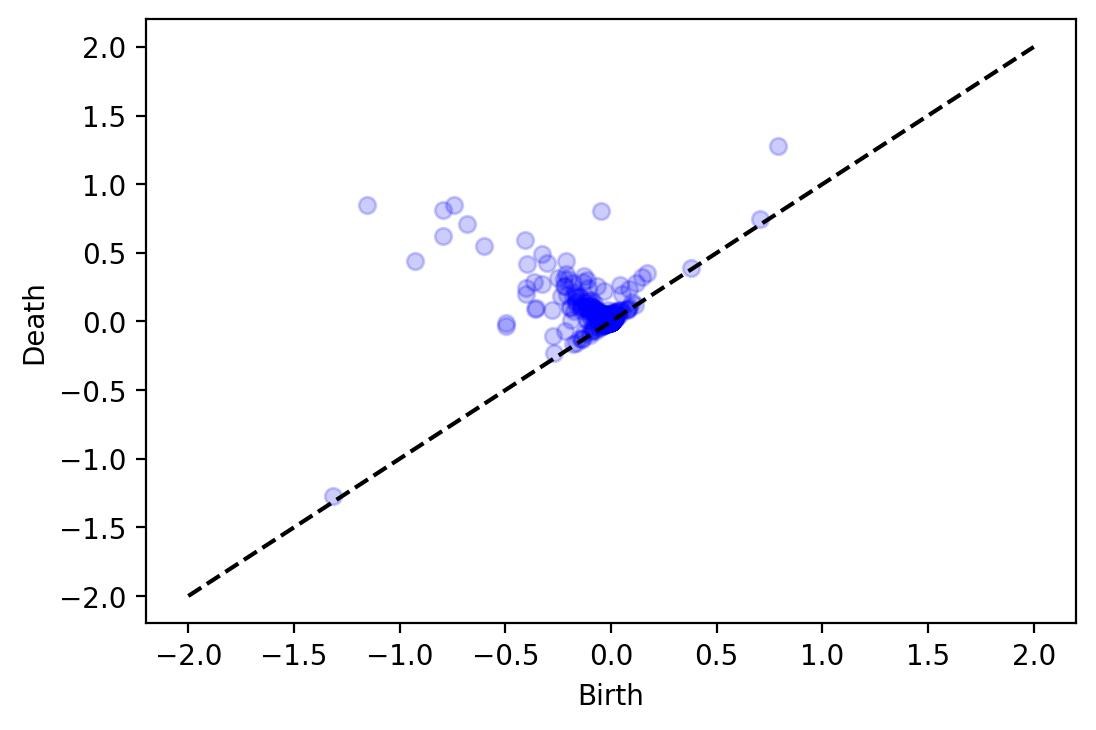

In [40]:
dt = PH_0dim[0].reshape((PH_0dim[0].shape[1],3))
plt.figure(dpi=200)
plt.scatter(dt[:,0],dt[:,1],c='b',alpha=1/5)
#plt.plot([min(WFTs[0])*1e+24, max(WFTs[0])*1e+24], [min(WFTs[0])*1e+24, max(WFTs[0])*1e+24],'k--')
plt.plot([-2,2], [-2,2],'k--')
plt.xlabel('Birth')
plt.ylabel('Death')

In [17]:
len(PH_0dim[0])

1

## first-order persistent landscape

In [7]:
from gtda.diagrams import PersistenceLandscape #这个更符合需求
# from teaspoon.MakeData.PointCloud import testSetManifolds
# from teaspoon.ML import feature_functions as Ff

In [19]:
# 构建1st-order PL
PL = PersistenceLandscape(n_bins=200)
PL_1st = []
for index,data in enumerate(PH_0dim):
    X = np.zeros((len(data),3))
    if bool(len(data)):
        X[:,0:2] = data #有空数组就会报错
    X_3dim = X[np.newaxis,:,:]
    pl = PL.fit_transform(X_3dim)
    PL_1st.append(pl.reshape(200))

(1, 3524, 3)


ValueError: could not broadcast input array from shape (3524,3) into shape (3524,2)

In [20]:
# 构建1st-order PL
PL = PersistenceLandscape(n_bins=200)
PL_1st = []
for index,data in enumerate(PH_0dim):
    X_3dim = data
    pl = PL.fit_transform(X_3dim)
    PL_1st.append(pl.reshape(200))

Text(0.5, 1.0, '1-order persistence landscape')

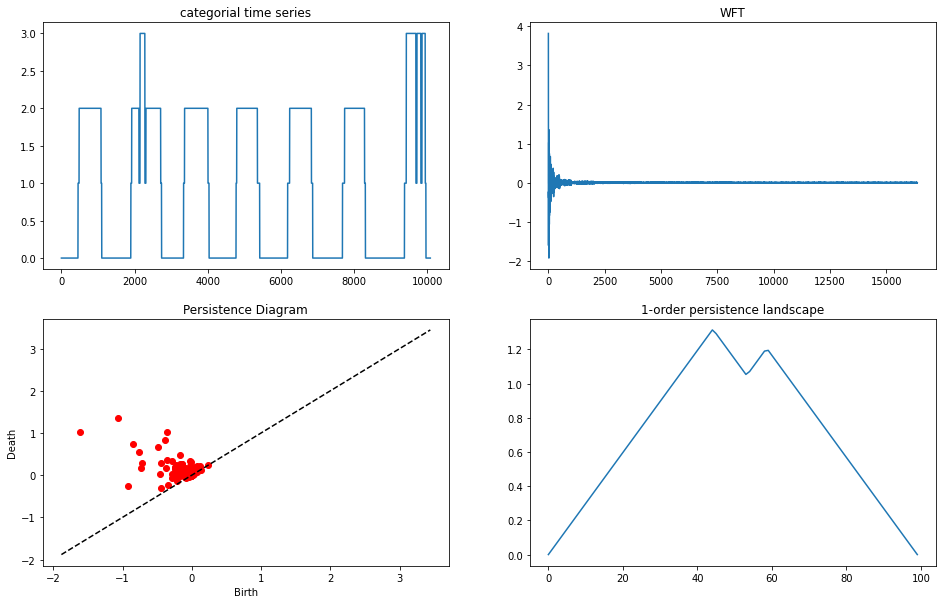

In [81]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

ax[0,0].plot(trajectory[0])
ax[0,0].set_title('categorial time series')

ax[0,1].plot(WFTs[0])
ax[0,1].set_title('WFT')

ax[1,0].plot(PH_0dim[0][:,0],PH_0dim[0][:,1],'ro')
ax[1,0].plot([min(WFTs[1]), max(WFTs[1])], [min(WFTs[1]), max(WFTs[1])],'k--')
ax[1,0].set_title('Persistence Diagram') 
ax[1,0].set_xlabel('Birth')
ax[1,0].set_ylabel('Death')

ax[1,1].plot(PL_1st[0])
ax[1,1].set_title('1-order persistence landscape') 


Text(0.5, 0, 'bins')

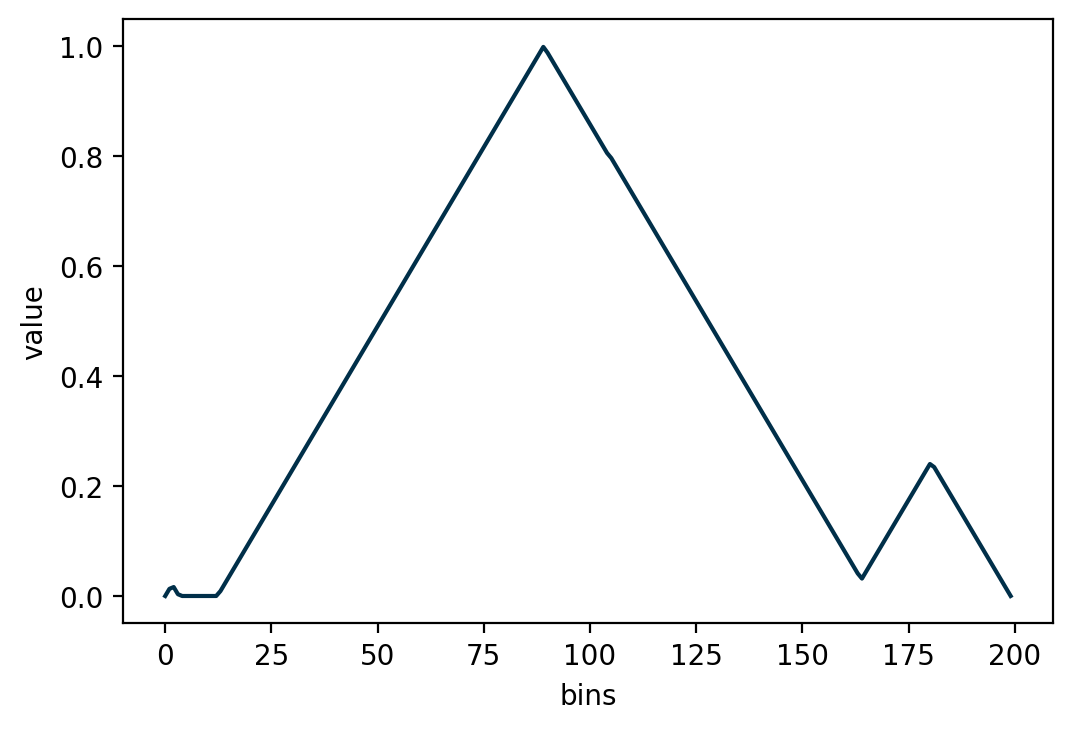

In [42]:
plt.figure(dpi=200)
plt.plot(PL_1st[0],c=[0,47/255,73/255])
plt.ylabel('value')
plt.xlabel('bins')

In [82]:
# 将一阶持续景观保存到txt
np.savetxt("data/1st_order_pl.txt", PL_1st)

## 方法改进：从persistence diagram中的特征提取

### from persistence diagram to representation

In [27]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=100, n_jobs=-1)
im8_heat = heat.fit_transform(PH_0dim[0])

# Visualise the heat kernel for H1
heat.plot(im8_heat, homology_dimension_idx=0, colorscale='jet')

### Building a full-blown feature extraction pipeline

In [32]:
PH_0dim[0].shape

(1, 3524, 3)

In [33]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration
from gtda.diagrams import Amplitude

#Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

# tda_union = make_union(
#     *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
#     n_jobs=-1
# )

In [34]:
Features = []
for index,data in enumerate(PH_0dim):
    feature = feature_union.fit_transform(data)
    Features.append(feature)
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [41]:
Features_reshape = np.array(Features).reshape(np.array(Features).shape[0],np.array(Features).shape[2])

In [47]:
# 保存特征！！！
np.savetxt("data/persistence_features_week_2019_58.txt", Features_reshape)

## time series转time delay embedding（不合适）

In [19]:
ts_test = trajectory_in_week[0]

Text(0.5, 1.0, 'Takens’ Embedding')

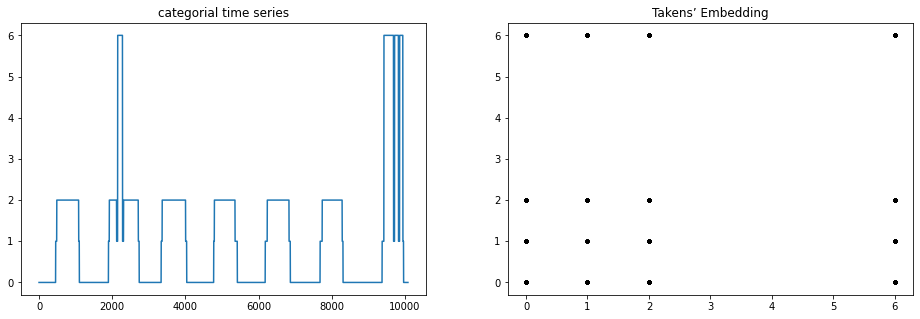

In [23]:
from teaspoon.SP.tsa_tools import takens
embedded_ts = takens(ts_test, n = 2, tau = 100)


fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(ts_test)
ax[0].set_title('categorial time series')

ax[1].plot(embedded_ts.T[0], embedded_ts.T[1], 'k.')
ax[1].set_title('Takens’ Embedding')

##  Network Representation of Time Series

In [25]:
from teaspoon.SP.network import knn_graph
from teaspoon.SP.network import ordinal_partition_graph

A_knn = knn_graph(ts_test,n = 2, tau = 100) #knn network from time series

A_op = ordinal_partition_graph(ts_test,n = 2, tau = 100) #ordinal partition network from time series

C:\ProgramData\Anaconda3\lib\site-packages\teaspoon\SP\..\parameter_selection\MI_delay.py:503: RuntimeWarning: divide by zero encountered in log
  I_matrix = Pxy*np.log(Pxy/(Px*Py))
C:\ProgramData\Anaconda3\lib\site-packages\teaspoon\SP\..\parameter_selection\MI_delay.py:503: RuntimeWarning: invalid value encountered in multiply
  I_matrix = Pxy*np.log(Pxy/(Px*Py))


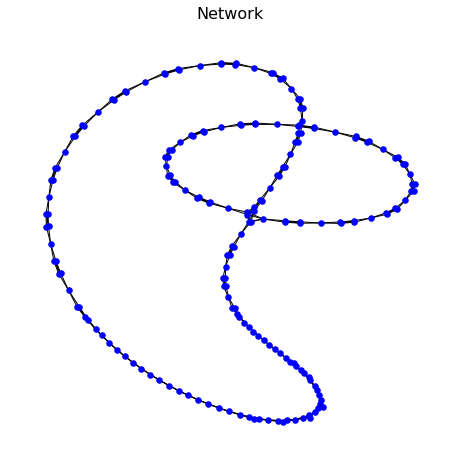

In [32]:
t = np.linspace(0,30,200)
ts = np.sin(t) + np.sin(2*t) #generate a simple time series

from teaspoon.SP.network import knn_graph
A = knn_graph(ts)

from teaspoon.SP.network_tools import make_network
G, pos = make_network(A)


import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize = (8,8))
plt.title('Network', size = 16)
nx.draw(G, pos, with_labels=False, font_weight='bold', node_color='blue',
        width=1, font_size = 10, node_size = 30)
plt.show()

# 为提升聚类效果而进行的改进

## 1. 精简ptype：0-居家，1-出行，2-家外活动

In [10]:
#原始ptype：0-到访，1-居住，2-工作，3-出行，
#现在，令0-居住（基点），1-出行，2-家外活动（即包括工作和到访）
dict_ = {0:2, 1:0, 2:2}
act_points1['ptype'] = act_points1['ptype'].map(dict_)

In [14]:
act_points1['ptype'].value_counts()

0    12979
2     9709
Name: ptype, dtype: int64

Text(0.5, 1.0, 'categorial time series')

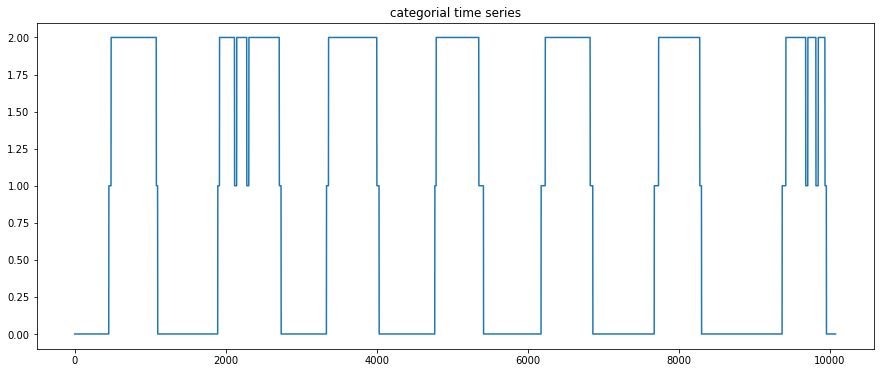

In [18]:
# 画个图看看
plt.figure(figsize=(15,6))
plt.plot(trajectory_in_week[0])
plt.title('categorial time series')

In [19]:
# 删除整周在家的轨迹（自成一类，不需分析）
trajectory_out = trajectory_in_week
for index,data in enumerate(trajectory_out):
    #print(data)
    if (~data.any()):
        trajectory_out = trajectory_out.drop(index = index)

trajectory = trajectory_out.reset_index(drop = True)

In [21]:
len(trajectory)

1017

In [20]:
#转化为ndarry方便保存
Trajectory_in_week = []
for i in range(len(trajectory)):
    Trajectory_in_week.append(trajectory[i])

In [22]:
#保存一下
np.savetxt("data/trajectory_in_week_2ptype.txt", Trajectory_in_week)

Text(0.5, 1.0, '1-order persistence landscape')

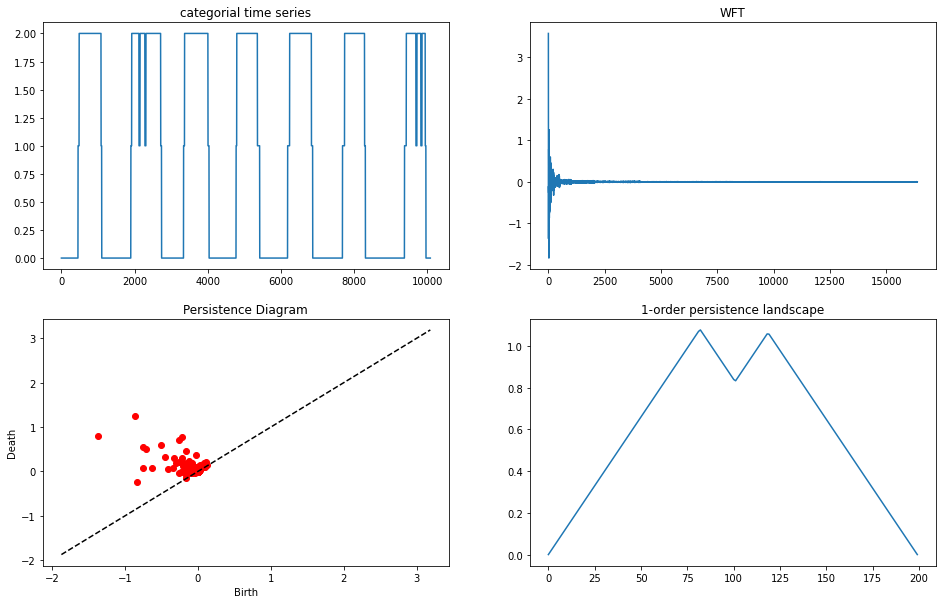

In [31]:
# 画图展示每个步骤的结果
fig, ax = plt.subplots(2,2,figsize=(16,10))

ax[0,0].plot(trajectory[0])
ax[0,0].set_title('categorial time series')

ax[0,1].plot(WFTs[0])
ax[0,1].set_title('WFT')

ax[1,0].plot(PH_0dim[0][:,0],PH_0dim[0][:,1],'ro')
ax[1,0].plot([min(WFTs[1]), max(WFTs[1])], [min(WFTs[1]), max(WFTs[1])],'k--')
ax[1,0].set_title('Persistence Diagram') 
ax[1,0].set_xlabel('Birth')
ax[1,0].set_ylabel('Death')

ax[1,1].plot(PL_1st[0])
ax[1,1].set_title('1-order persistence landscape') 

In [32]:
# 将一阶持续景观保存到txt
np.savetxt("data/1st_order_pl_2ptype.txt", PL_1st)

## 2. 更换数据源

In [4]:
#读取数据
filename = 'data/stay_one_community_2019.csv'
act_points2019 = pd.read_csv(filename,parse_dates=['t_start', 't_end'])
act_points2019['date'] = pd.to_datetime(act_points2019['date'],format='%Y-%m-%d')
act_points2019.head()

,pid,date,t_start,t_end,poi_id,community_id,ptype,longitude,latitude,week,weekday
0,90221,2019-05-06,2019-05-06 07:28:00,2019-05-06 22:51:56,1,2291,2,114.185092,22.651382,19,0
1,90221,2019-05-07,2019-05-07 00:52:01,2019-05-07 11:44:26,0,2291,1,114.174066,22.640383,19,1
2,90221,2019-05-07,2019-05-07 12:09:41,2019-05-07 13:39:58,0,2291,1,114.174066,22.640383,19,1
3,90221,2019-05-07,2019-05-07 13:41:28,2019-05-07 16:42:16,1,2291,2,114.185092,22.651382,19,1
4,90221,2019-05-07,2019-05-07 16:43:47,2019-05-07 23:14:57,0,2291,1,114.174066,22.640383,19,1


In [3]:
# 2ptype
#原始ptype：0-到访，1-居住，2-工作，3-出行，
#现在，令0-居住（基点），1-出行，2-家外活动（即包括工作和到访）
dict_ = {0:2, 1:0, 2:2}
act_points2019['ptype'] = act_points2019['ptype'].map(dict_)

In [5]:
# 3ptype
#原始ptype：0-到访，1-居住，2-工作，3-出行，
#现在，令0-居住（基点），1-出行，2-工作，3-到访（即其他活动）
dict_ = {0:3, 1:0, 2:2}
act_points2019['ptype'] = act_points2019['ptype'].map(dict_)

### 选取4个月的数据（5~8月）

In [6]:
# 生成月份标签
act_points2019['month'] = [data.month for data in act_points2019['date']]

# 月份选取
act_points2019_58 = act_points2019.query('month in [5,6,7,8]')

In [9]:
act_points2019_58.to_csv('data/act_201958.csv',index=False)

In [18]:
# 对个体和周序号分组求序列
trajectory_groups_in_week = act_points2019_58.groupby(['pid','week'],group_keys=False)
trajectory_in_week1 = trajectory_groups_in_week.apply(act_2_sequence_in_week).reset_index(drop = True)
trajectory_in_week1.head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [19]:
#对个体和日期分组求序列
trajectory_groups_in_day = act_points2019_58.groupby(['pid','date'],group_keys=False)
trajectory_in_day = trajectory_groups_in_day.apply(act_2_sequence_in_day).reset_index(drop=True)
trajectory_in_day.head()

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

In [20]:
print(len(trajectory_in_day),len(trajectory_in_week))

8126 1335


Text(0.5, 1.0, 'categorial time series')

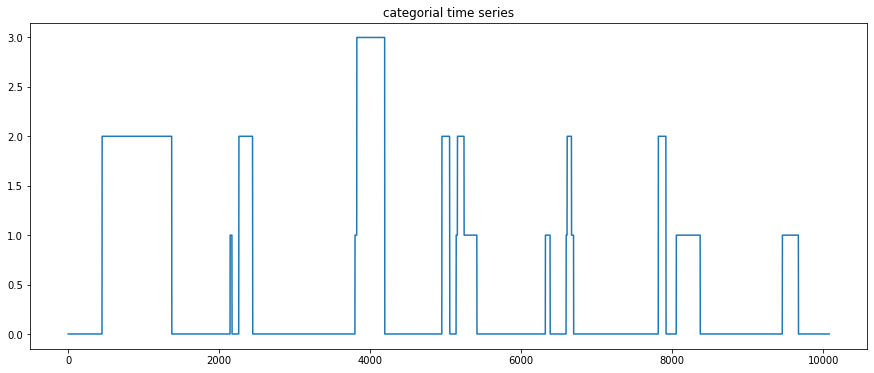

In [22]:
# 画个图看看
plt.figure(figsize=(15,6))
plt.plot(trajectory_in_week[0])
plt.title('categorial time series')

In [23]:
# 删除整周在家的轨迹（自成一类，不需分析）
trajectory_out = trajectory_in_week
for index,data in enumerate(trajectory_out):
    #print(data)
    if (~data.any()):
        trajectory_out = trajectory_out.drop(index = index)

trajectory = trajectory_out.reset_index(drop = True)
print(len(trajectory))

1316


In [19]:
# 这段代码是为了提取pid
# 删除整周在家的轨迹（自成一类，不需分析）
trajectory_out = trajectory_in_week1
for index,data in enumerate(trajectory_out):
    #print(data)
    if not data.any():
        trajectory_in_week = trajectory_in_week.drop(index = index)

trajectory_in_week = trajectory_in_week.reset_index(drop = True)
print(len(trajectory_in_week))

np.savetxt('data/pidindex_week_2019_58.txt',np.array(trajectory_in_week['pid']))

1316


In [24]:
#转化为ndarry方便保存
Trajectory_in_week = []
for i in range(len(trajectory)):
    Trajectory_in_week.append(trajectory[i])

#保存一下
np.savetxt("data/trajectory_in_week_3ptype_2019_58.txt", Trajectory_in_week)

In [25]:
#转化为ndarry方便保存
Trajectory_in_day = []
for i in range(len(trajectory_in_day)):
    Trajectory_in_day.append(trajectory_in_day[i])

#保存一下
np.savetxt("data/trajectory_in_day_3ptype_2019_58.txt", Trajectory_in_day)

Text(0.5, 1.0, '1-order persistence landscape')

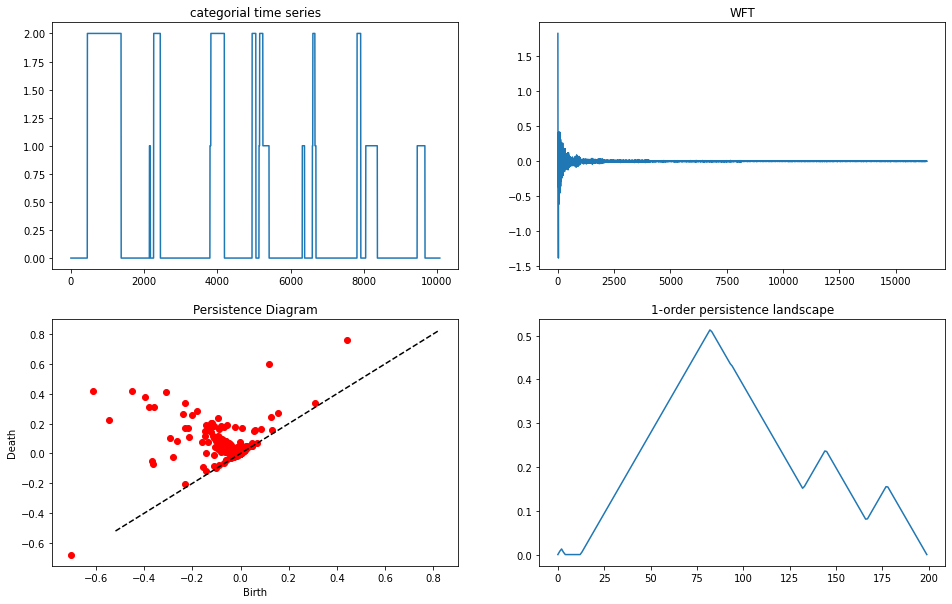

In [55]:
# 画图展示每个步骤的结果
fig, ax = plt.subplots(2,2,figsize=(16,10))

ax[0,0].plot(trajectory[0])
ax[0,0].set_title('categorial time series')

ax[0,1].plot(WFTs[0])
ax[0,1].set_title('WFT')

ax[1,0].plot(PH_0dim[0][:,0],PH_0dim[0][:,1],'ro')
ax[1,0].plot([min(WFTs[0]), max(WFTs[0])], [min(WFTs[0]), max(WFTs[0])],'k--')
ax[1,0].set_title('Persistence Diagram') 
ax[1,0].set_xlabel('Birth')
ax[1,0].set_ylabel('Death')

ax[1,1].plot(PL_1st[0])
ax[1,1].set_title('1-order persistence landscape') 

In [57]:
# 将一阶持续景观保存到txt
np.savetxt("data/1st_order_pl_2ptype_2019.txt", PL_1st)

## 3.时间序列转换特征

参考：https://www.163.com/dy/article/FTV96IUF0511FQO9.html

### （1）高维空间转换特征
高维空间转换特征直白点说就是把一维的时序转化到高维。这个高维可能是二维（例如图片），或者更高维（例如相空间重构）。这种转换可以使得时序的信息被放大，从而暴露更多的隐藏信息。同时，这种方法增加了数据分析的计算量，**一般不适用于大规模的时序分析**。

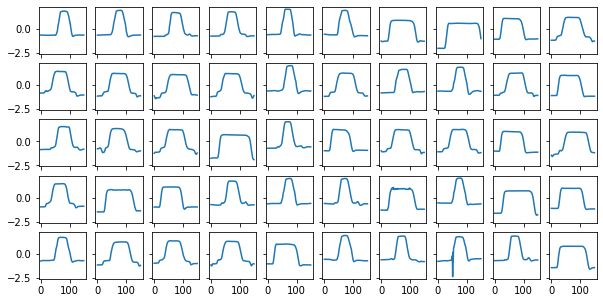

In [12]:
# Load the GunPoint dataset
from pyts.datasets import load_gunpoint
X, _, _, _ = load_gunpoint(return_X_y=True)

fig, ax = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(10,5))
for i in range(5):
        for j in range(10):
            flag = i * 10 + j
            ax[i,j].plot(X[flag])

In [13]:
X

array([[-0.6478854 , -0.64199155, -0.63818632, ..., -0.64042873,
        -0.63866571, -0.63865722],
       [-0.64442658, -0.64540093, -0.64705511, ..., -0.6349345 ,
        -0.6344968 , -0.63159565],
       [-0.77835282, -0.77827907, -0.77715084, ..., -0.70419626,
        -0.70760524, -0.7071202 ],
       ...,
       [-0.77912617, -0.77837863, -0.7757449 , ..., -0.50500603,
        -0.50373099, -0.50438486],
       [-0.70303339, -0.70261754, -0.70250356, ..., -0.64113375,
        -0.64140622, -0.64210896],
       [-1.4357199 , -1.4322717 , -1.4329285 , ..., -1.4354619 ,
        -1.4352821 , -1.4308845 ]])

In [3]:
# 导入原始轨迹数据
trajectory_2ptype_2019 = np.loadtxt('data/trajectory_in_week_2ptype_2019.txt')

In [4]:
trajectory_test = trajectory_2ptype_2019[0:2]
trajectory_test.shape

(2, 10080)

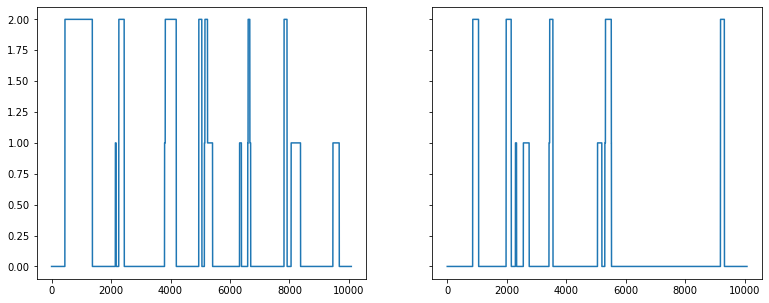

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13,5))
for i in range(2):
    ax[i].plot(trajectory_2ptype_2019[i])

① 格雷姆角场（GAF）
该转化在笛卡尔坐标系下，将一维时间序列转化为极坐标系表示，再使用三角函数生成GAF矩阵
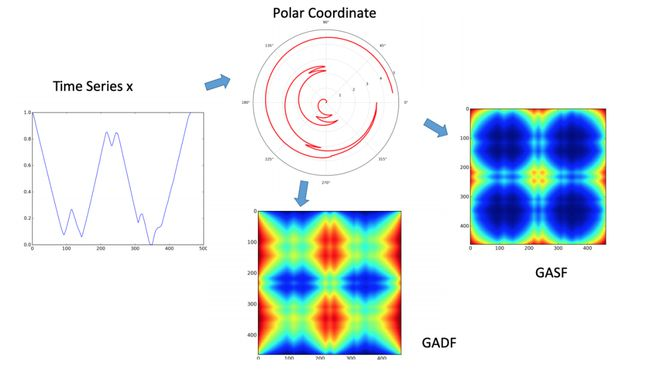

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField

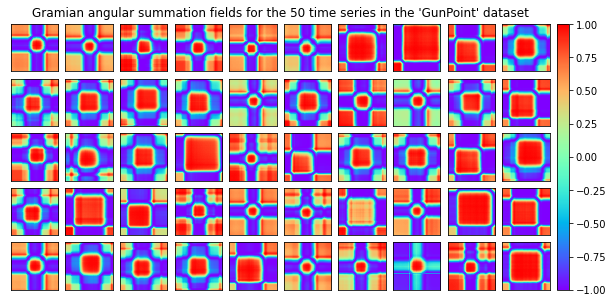

In [23]:

# Load the GunPoint dataset
X, _, _, _ = load_gunpoint(return_X_y=True)

# Get the Gramian angular summation fields for all the time series
gaf = GramianAngularField()
X_gaf = gaf.fit_transform(X)

# Plot the 50 Gramian angular fields
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(X_gaf[i], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Gramian angular summation fields for the 50 time series in the "
             "'GunPoint' dataset", y=0.92)

plt.show()

In [8]:
X = trajectory_test
#X = X[np.newaxis,:]

# Get the Gramian angular summation fields for all the time series
gaf = GramianAngularField()
X_gaf1 = gaf.fit_transform(X)
print(X_gaf1.shape)

(2, 10080, 10080)


In [17]:
X_gaf[0:2]

array([[[0.61134994, 0.60334931, 0.59823601, ..., 0.60124443,
         0.59887801, 0.59886663],
        [0.60334931, 0.59528748, 0.59013574, ..., 0.59316671,
         0.59078253, 0.59077107],
        [0.59823601, 0.59013574, 0.58495985, ..., 0.588005  ,
         0.58560966, 0.58559815],
        ...,
        [0.60124443, 0.59316671, 0.588005  , ..., 0.59104183,
         0.58865304, 0.58864156],
        [0.59887801, 0.59078253, 0.58560966, ..., 0.58865304,
         0.5862591 , 0.58624759],
        [0.59886663, 0.59077107, 0.58559815, ..., 0.58864156,
         0.58624759, 0.58623608]],

       [[0.5349179 , 0.53616538, 0.53828827, ..., 0.52287638,
         0.52232585, 0.51868702],
        [0.53616538, 0.53741168, 0.53953257, ..., 0.52413495,
         0.52358492, 0.51994937],
        [0.53828827, 0.53953257, 0.54165005, ..., 0.52627682,
         0.52572764, 0.5220977 ],
        ...,
        [0.52287638, 0.52413495, 0.52627682, ..., 0.5107296 ,
         0.51017433, 0.5065044 ],
        [0.5

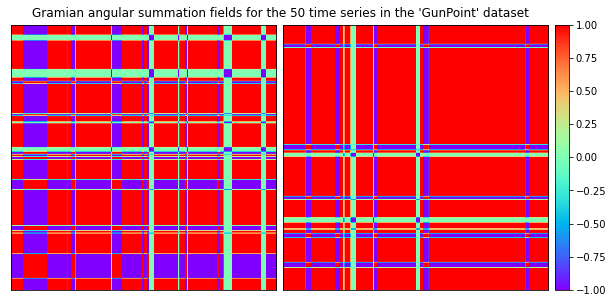

In [9]:
# Plot the 50 Gramian angular fields
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(X_gaf1[i], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Gramian angular summation fields for the 50 time series in the "
             "'GunPoint' dataset", y=0.92)

plt.show()

② 马尔科夫随机场（MRF）
MRF的基本思想是将时间序列的值状态化，然后计算时序的转化概率，其构建的是一个概率图（Graph），一种无向图的生成模型，主要用于定义概率分布函数。
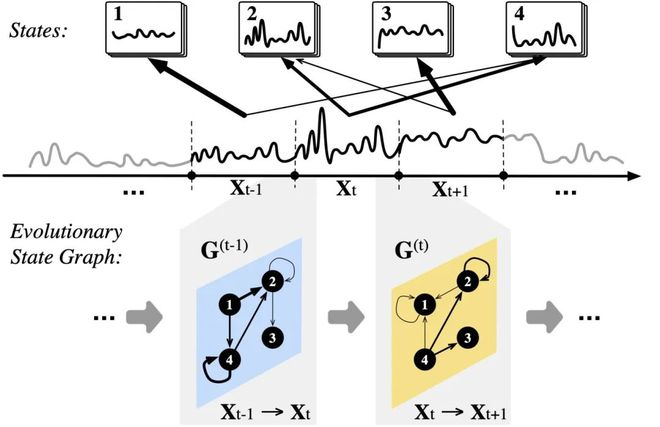

In [36]:
from pyts.image import MarkovTransitionField

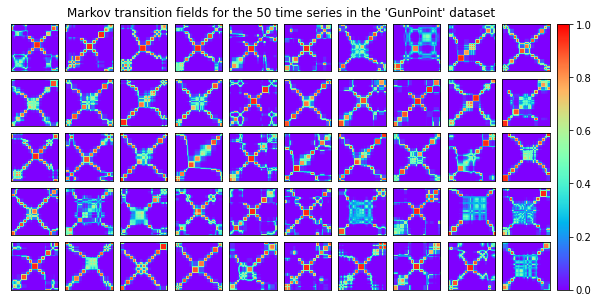

In [15]:
# Load the GunPoint dataset
X, _, _, _ = load_gunpoint(return_X_y=True)

# Get the recurrence plots for all the time series
mtf = MarkovTransitionField(n_bins=8)
X_mtf = mtf.fit_transform(X)

# Plot the 50 Gramian angular fields
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(X_mtf[i], cmap='rainbow', origin='lower', vmin=0., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Markov transition fields for the 50 time series in the "
             "'GunPoint' dataset", y=0.92)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning:

Some quantiles are equal. The number of bins will be smaller for sample [0 1]. Consider decreasing the number of bins or removing these samples.



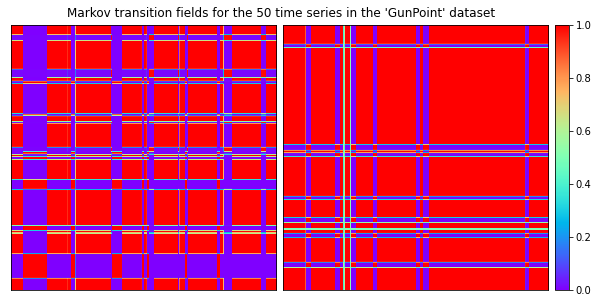

In [40]:
# Load the GunPoint dataset
#X, _, _, _ = load_gunpoint(return_X_y=True)
X = trajectory_test

# Get the recurrence plots for all the time series
mtf = MarkovTransitionField(n_bins=4)
X_mtf = mtf.fit_transform(X)

# Plot the 50 Gramian angular fields
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(X_mtf[i], cmap='rainbow', origin='lower', vmin=0., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle("Markov transition fields for the 50 time series in the "
             "'GunPoint' dataset", y=0.92)

plt.show()

In [39]:
X_mtf.shape

(2, 10080, 10080)

③ 时频分析（已用）

### （2）分类特征
**分类特征一般结合具体的任务，比如时序预测，时序分类等**，常常有标签（Label）信息来引导，其分析的特征也为具体的任务所服务，是一类常用的特征分析方法，一般通过机器学习中的有监督方式进行抽取。

① 形态特征（shapelet）
旨在捕捉时间序列分类任务中作为分类依据的有代表性的子序列形状。
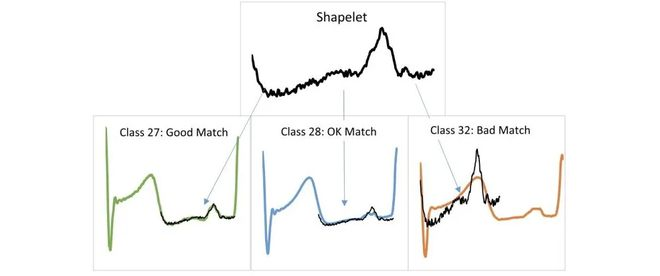

### （3）其他时频转换（Fast Walsh Hadamard Transform）

In [5]:
from sympy import fwht

In [3]:
len(trajectory_2ptype_2019)

2281

In [6]:
# test = trajectory_2ptype_2019[0]
# trans = fwht(test) #list

FWHTs = []

for index,data in enumerate(trajectory_2ptype_2019):
    fwht_seq = fwht(data)
    FWHTs.append(np.array(fwht_seq)*1e-3)
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


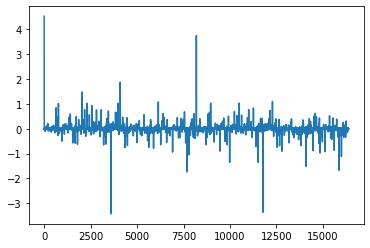

In [76]:
plt.plot(trans)

In [10]:
# 用sublevel set function对FWHT作持续同调，提取0维birth-death点

PH_0dim = []
for index,data in enumerate(FWHTs):
    feature_ind_1, feature_ind_2, persistenceDgm = Persistence0D(data) 
    #indices of birth times, indices of death times, points set
    PH_0dim.append(persistenceDgm)


In [11]:
# 构建1st-order PL
PL = PersistenceLandscape(n_bins=200)

PL_1st = []
for index,data in enumerate(PH_0dim):
    #print(data)
    X = np.zeros((len(data),3))
    X[:,0:2] = data #有空数组就会报错
    X_3dim = X[np.newaxis,:,:]
    pl = PL.fit_transform(X_3dim)
    PL_1st.append(pl.reshape(200))

In [79]:
np.array(PL_1st).shape

(200,)

Text(0.5, 1.0, '1-order persistence landscape')

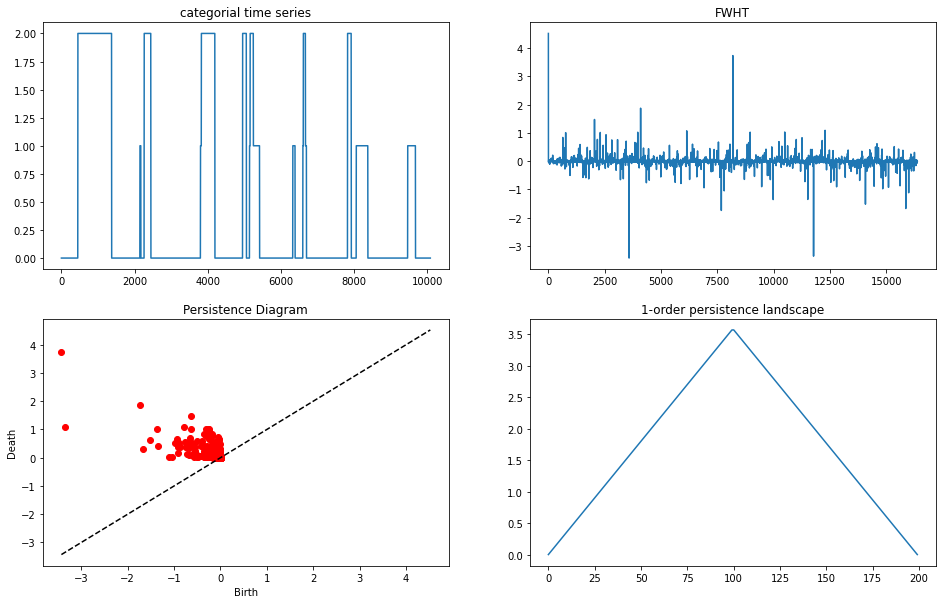

In [15]:
# 画图展示每个步骤的结果
fig, ax = plt.subplots(2,2,figsize=(16,10))

ax[0,0].plot(trajectory_2ptype_2019[0])
ax[0,0].set_title('categorial time series')

ax[0,1].plot(FWHTs[0])
ax[0,1].set_title('FWHT')

ax[1,0].plot(PH_0dim[0][:,0],PH_0dim[0][:,1],'ro')
ax[1,0].plot([min(FWHTs[0]), max(FWHTs[0])], [min(FWHTs[0]), max(FWHTs[0])],'k--')
ax[1,0].set_title('Persistence Diagram') 
ax[1,0].set_xlabel('Birth')
ax[1,0].set_ylabel('Death')

ax[1,1].plot(PL_1st[0])
ax[1,1].set_title('1-order persistence landscape') 

In [14]:
# 将一阶持续景观保存到txt
np.savetxt("data/1st_order_pl_2ptype_2019_FWHT.txt", PL_1st)